# Signal Detection Measures & ROC Analysis

## Background

When attempting to make a binary classification, there are four possible outcomes:

|      | Positive | Negative   |
|------|------|------|
|   **Judge "Positive"**   |   True Positive  | False Positive|
|   **Judge "Negative"**   |   False Negative  | True Negative|

1. We can make a "positive" judgement when the truth is positve (True Positive)
2. We can make a "positive" judgement when the truth is negative (False Positive)
3. We can make a "negative" judgement when the truth is positve (False Negative)
4. We can make a "negative" judgement when the truth is negative (True Negative)

True positives and false negatives are redundant, as are false positives and true negatives. This means we can consider just the true positives and the false positives. By considering the tradeoffs between true and false positives, we can gain insights into the ability of the "classifier" to discriminate between the true classes, as well as the level of bias.

This has many applications:
- medical diagnoses
- machine learning classification 
- hypothesis testing
- analysis of recognition memory ability

A measure of discrimination is $d`$, which is the distance between the $z$ scores of the false and true positive rates. A popular bias measure is $C$, which is the distance between the criterion and the neutral point, where the signal and noise distributions cross.

$d' = \phi^{-1}(TP) - \phi^{-1}(FP)$ 


$C = \frac{\phi^{-1}(TP) + \phi^{-1}(FP)}{2}$

## Assumptions & Requirements

The data must meet some requirements. First, the scenario must be a binary signal detection problem. Examples:
1. "is the target present? (y/n)"
2. "do you remember this word? (y/n)"
3. "did you hear the sound? (y/n)"
4. "did the outcome occur? (y/n)"

The dataset used should contain a column denoting the ground truth outcome for that row's observation. The values of this column should be binary as in `{"y","n"}`, `{1,0}`, etc. This is referred to as `y_true`, since it is the true outcome.

A similar column should also exist denoting the response provided by the "classifier". Examples of this would be a person detecting a signal/remembering an item etc, or it could be the output/prediction of a classification algorithm given a set of input features. The values of this column should also be binary, but in case some responses are missed then missing values are allowed. This is referred to as `y_classified`, since it is the outcome of some classification decision.

An identifier column should also exist indicating the subject/classifier name/label. This is referred to as `identifier` in the code.

A grouping column should exist indicating which of any different conditions an observation belongs to. This is referred to as `grouper`.

For any ROC analysis, a column should also exist indicating the particular response, within a given range (e.g. on a scale; `[1,2,3,4,5,6]`), that was made by the classifier. In this example, this was a subjective confidence rating during a recognition memory task. This is referred to as `responses`.

Scroll down to below the functions to see the outputs.

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# Basic plotting parameters
rc = {'font.family':'cambria', 'font.size':28}
sns.set(style='darkgrid', rc=rc)

## Getting the data

In [2]:
def get_datafiles(data_path, file_kw, file_extension):
    files = [f'{data_path}\\{f}' for f in os.listdir(data_path) if (file_kw in f) and (file_extension in f)]
    return files

In [3]:
# Loop over the datasets, get them as dataframes, append to respective list
def aggregate_data(data_files):
    
    aggregated = []
    for f in tqdm(data_files):
        
        df = pd.read_csv(f)#.drop('Unnamed: 65', axis=1)

#         # Filter out practice 
#         df['run_type'] = df['stimulus_file'].str.split('_', expand=True)[0]
#         df = df.loc[df['run_type'] != 'practice'].reset_index(drop=True)

        df.columns = [c.replace('.', '_') for c in df.columns]
        
        df = df[[c for c in df.columns if 'Unnamed' not in c]]
        
        aggregated.append(df)
    return pd.concat(aggregated, axis=0)

## Encode the stimulus and response classes (old, new), and response types (H,FA,CR,M)

To make it more generalisable, have a way to encode true and predicted classes as binary values

In [4]:
def binary_class_encode(data, column, positive_class, negative_class):
    return data[column].replace({positive_class:1,negative_class:0}).copy()

Create response types (hits, false alarms, misses, correct rejections). Can change the names e.g. to anything within reason.

In [5]:
def encode_response_types(data, y_true, y_classified, target='response_type', tp='H', fp='FA', tn='CR', fn='M'):
    data = data[[y_true, y_classified]].copy() # prevent copy warning
    data.loc[(data[y_true]==1) & (data[y_classified]==1), target] = tp
    data.loc[(data[y_true]==0) & (data[y_classified]==1), target] = fp
    data.loc[(data[y_true]==0) & (data[y_classified]==0), target] = tn
    data.loc[(data[y_true]==1) & (data[y_classified]==0), target] = fn
    return data[target]

## Compute Signal Detection Performance (Discriminability & Bias)

After using the above functions, the dataset is cleaned up and the important columns have the correct format.

Get dummy variables for the response type column. We could simply use `pd.get_dummies()` but if a subject happens to not respond with a certain type (e.g. always hits) then some types will not exist and the dummies will be incorrect.

In [6]:
def dummify_response_types(data, y_true, y_classified, response_type_column,
                          tp='H', fp='FA', tn='CR', fn='M'):
    # Takes the column containing hit, miss, cr, fa and makes dummy variables for them.
    
    data = data.copy()
    
    response_types = [tp, fp, tn, fn]
    for rtype in response_types:
        data[rtype] = 0

    data.loc[(data[y_true]==1) & (data[y_classified]==1), tp] = 1 # ground truth is positive, classed as positive (TP).
    data.loc[(data[y_true]==0) & (data[y_classified]==1), fp] = 1 # ground truth is negative, classed as positive (FP).
    data.loc[(data[y_true]==1) & (data[y_classified]==0), fn] = 1 # ground truth is positive, classed as negative (M).
    data.loc[(data[y_true]==0) & (data[y_classified]==0), tn] = 1 # ground truth is negative, classed as negative (TN).

    return data[response_types]

Splitting the data into 'signal present' and 'signal absent' datasets makes it easier to do the calculations.

In [7]:
def signal_noise_split(data, y_true, y_classified, response_type_column, 
                       tp='H', fp='FA', tn='CR', fn='M'):
    # Splits the data into a signal (hits and misses) and a noise (fa and cr) dataset
    
    data = data.copy()
    
    resp_dummies = dummify_response_types(data, y_true, y_classified, response_type_column, tp, fp, tn, fn)
    data = pd.concat([data, resp_dummies], axis=1)
    
    signal = data.loc[data[response_type_column].isin([tp, fn])].drop([fp, tn], axis=1).reset_index()
    noise = data.loc[data[response_type_column].isin([fp, tn])].drop([tp, fn], axis=1).reset_index()
    
    return signal, noise

Computing d-prime and bias measure. Could add some more measures but these work fine.

In [8]:
def signal_detection(data, y_true, y_classified, response_type_column, identifier, grouper, tp='H', fp='FA', tn='CR', fn='M'):
    # Grouping column allows to fit SDT measures for each condition.
    # Returns a summary dataframe containing dprime and c bias, along with the response types
    
    signal_data, noise_data = signal_noise_split(data=data, y_true=y_true, y_classified=y_classified, 
                                                 response_type_column=response_type_column)

    # Grouped true positive data (convert from resp counts to freqs)
    gsignal = signal_data.groupby([identifier, grouper], as_index=False)[[tp, fn]].apply(lambda x: x.sum() / x.count())

    # Grouped true negative data (convert from resp counts to freqs)
    gnoise = noise_data.groupby([identifier, grouper], as_index=False)[[fp, tn]].apply(lambda x: x.sum() / x.count()).reset_index()

    # Join the negative data onto the positive so we can use vectorisation
    summary_data = gsignal.join(other=gnoise.set_index(identifier).drop(grouper, axis=1))#.reset_index()

    # Compute dprime and c_bias
    summary_data['d_prime'] = stats.norm.ppf(summary_data[tp]) - stats.norm.ppf(summary_data[fp])
    summary_data['c_bias'] = -(stats.norm.ppf(summary_data[tp]) + stats.norm.ppf(summary_data[fp])) / 2

    # Compute more measures here from S&T (1996)?
    return summary_data.reset_index()

In [9]:
def plot_signal_detection(discrimination, bias, signal_variance=1, title=None):
    
    if title:
        title = '\n'+title # add a new lne character\
    else:
        title=''
    
    signal = discrimination
    noise = 0
    
    noise_sigma = np.sqrt(1)
    signal_sigma = np.sqrt(signal_variance)
    
    signal_x = np.linspace(signal - 3 * signal_sigma, signal + 3 * signal_sigma, 100)
    signal_y = stats.norm.pdf(signal_x, signal, signal_sigma)
    
    noise_x = np.linspace(noise - 3 * noise_sigma, noise + 3 * noise_sigma, 100)
    noise_y = stats.norm.pdf(noise_x, noise, noise_sigma)
    
    # your code here
    fig, ax = plt.subplots(figsize=(10,4), dpi=100)
    ax.plot(noise_x, noise_y, label='noise', c='gray')
    ax.plot(signal_x, signal_y, label='signal')
    ax.fill_between(x=noise_x, y1=noise_y, color='gray', alpha=1/3)
    ax.fill_between(x=signal_x, y1=signal_y, alpha=1/3)
    ax.axvline(signal)
    ax.axvline(0, c='gray')

    # Find where bias should be
    midpoint = 0 + (discrimination/2)
    biaspos = midpoint + bias
    dist_height = max([(max(signal_y) - max(noise_y)) / 2, max(noise_y)])
    
    # Plot the bias
    ax.plot([biaspos,biaspos], [0, dist_height], c='purple', lw=2.5)
    ax.text(x=biaspos*1.1, y=dist_height*.1, fontsize=12, s=f'bias: {bias:.2f}', c='purple')
    
    # Plot discrimination
    ax.plot([noise, signal], [dist_height,dist_height], marker='o', markeredgewidth=1, markeredgecolor='k', lw=2.5, c='C2')
    ax.text(x=signal*1.1, y=dist_height*1.005, s=f'discrimination: {discrimination:.2f}', c='darkgreen', fontsize=12)

    ax.set_title(f'Signal Detection Performance{title}')

    ax.legend()
    ax.get_yaxis().set_visible(False)
    plt.show()
    
    return

## Confidence & ROC Analysis (single subject)

This is easier to do for single subjects first, and can then be looped over for each subject (or just run independently)

In [10]:
def compute_roc(signal, noise):
    
    signal = np.cumsum(signal)
    noise = np.cumsum(noise)

    signal = np.array([(x + i / len(signal)) / (max(signal)+1) for i, x in enumerate(signal, start=1)])[:-1]
    noise = np.array([(x + i / len(noise)) /(max(noise)+1) for i, x in enumerate(noise, start=1)])[:-1]
    
    return signal, noise

In [11]:
def plot_roc(signal, noise, title=None):
    # signal and noise are both vectors.
    
    if title:
        title += '\n' # add a new lne character\
    else:
        title=''
    
    # np.trapz() doesn't like nan values.
    signal = signal[~np.isnan(signal)] # remove na from signal
    noise = noise[~np.isnan(noise)] # remove na from noise
    # Use np.trapz for AUC
    AUC = np.trapz(y=signal, x=noise)
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=100)
    ax.plot([0,1], [0,1], c='k', ls='dashed')
    ax.plot(noise, signal, marker='o')
    
    ax.set_title(f'{title}AUC = {AUC:.2f}')
    
    ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('1 - specificity')
    ax.set_ylabel('sensitivity')
    plt.show()
    
    return

Calculating the ROC data by accumulating across response types within each condition. Also gets the ROCs in z-space.

In [12]:
def roc(data, y_true, y_classified, response_type_column, grouper, responses,
        tp='H', fn='M', fp='FA', tn='CR'):
    
    data=data.copy()
    
    signal, noise = signal_noise_split(data, y_true, y_classified, response_type_column)

    # Get sum of all response types in each condition
    signal_conf = signal.groupby([grouper, responses])[[tp, fn]].sum().sort_values(by=[grouper, responses], ascending=[True, False])
    noise_conf = noise.groupby([grouper, responses])[[fp, tn]].sum().sort_values(by=[grouper, responses], ascending=[True, False])

    # Interpolate cases when a response key was unused to make sure it's in there

    # Get sum across all responses (collapsing across response type)
    signal_conf['signal_count'] = signal_conf.cumsum(axis=1).iloc[:, -1]
    noise_conf['noise_count'] = noise_conf.cumsum(axis=1).iloc[:, -1]

    response_df = signal_conf.join(other=noise_conf.reset_index().set_index(responses).drop(grouper, axis=1)).reset_index()

    # Sometimes subjects don't use all available responses, but this is a problem for calculating ROC
    # ROC needs all possible responses even if there were 0 cases, so we need to interpolate.
    response_df = response_df.set_index([grouper, responses]).unstack(fill_value=0).stack().reset_index()
    response_df = response_df.sort_values(by=[grouper, responses], ascending=[False, False]).reset_index(drop=True)
    
    for g in response_df[grouper].unique():
        # Loop over each level (g) of grouper
        gsignal = response_df.loc[response_df[grouper]==g]['signal_count'].values # get this group's signal
        gnoise = response_df.loc[response_df[grouper]==g]['noise_count'].values # ... and this group's noise

        signal_cf, noise_cf = compute_roc(gsignal, gnoise) # compute the ROC data
        
        # Compute the ROCs
        response_df.loc[response_df[grouper]==g, 'signal'] = np.append(signal_cf, [np.nan]) # put it into the df (append nan to the end because always len-1)
        response_df.loc[response_df[grouper]==g, 'noise'] = np.append(noise_cf, [np.nan])
        
        # Compute the ROCa in z-space
        z_signal = stats.norm.ppf(signal_cf)
        z_noise = stats.norm.ppf(noise_cf)
        response_df.loc[response_df[grouper]==g, 'z_signal'] = np.append(z_signal, [np.nan])
        response_df.loc[response_df[grouper]==g, 'z_noise'] = np.append(z_noise, [np.nan])
        
    return response_df

# Putting it together

### 1. Get the data

In [13]:
data_path = r'C:\Users\L\Google Drive\PhD\experiments\adapted_cueing\recognition\data'
files = get_datafiles(data_path, 'recognition', '.csv')
df = aggregate_data(files)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 33.88it/s]


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 305
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stimulus_file               612 non-null    object 
 1   trial_id                    612 non-null    int64  
 2   encoding_trial_id           612 non-null    object 
 3   list                        6 non-null      object 
 4   probe_stimulus              612 non-null    object 
 5   cue_stimulus                612 non-null    object 
 6   target_x                    612 non-null    object 
 7   cue_status                  612 non-null    object 
 8   dist_status                 612 non-null    object 
 9   dist_opacity                6 non-null      object 
 10  correct_response            6 non-null      object 
 11  stimulus_class              612 non-null    object 
 12  stimulus_type               612 non-null    object 
 13  files_thisRepN              612 non

### 2. Do some cleaning up*

*This is dataset-specific, and can be skipped if data is already in the correct format.

In [15]:
# Combine condition labels into single column for tidier analysis (should have been done before)
df['condition'] = df[['stimulus_type', 'dist_status', 'cue_status']].agg('_'.join, axis=1)
df.loc[df['condition'] == 'None_None_None', 'condition'] = 'new'
df['condition'].value_counts()

new                          246
target_standard_valid         64
target_salient_valid          62
distractor_salient_valid      60
target_none_invalid           60
distractor_standard_valid     60
target_none_valid             60
Name: condition, dtype: int64

In [16]:
# Convert the response keys to numeric and fill "None" with np.nan (should have been done before as well)
df['trial_resp_keys'] = pd.to_numeric(df['trial_resp_keys'].replace('None', np.nan))
print(f"{df['trial_resp_keys'].isnull().sum()} nan values")

41 nan values


In [17]:
# Create a response class column
df.loc[(~df['trial_resp_keys'].isnull()) & (df['trial_resp_keys'] > 3), 'response_class'] = 'old' # old
df.loc[(~df['trial_resp_keys'].isnull()) & (df['trial_resp_keys'] < 4), 'response_class'] = 'new' # new
df['response_class'].replace({'None':np.nan}) # MUST replace null values with np.nan!!!
df['response_class'].value_counts()

old    334
new    237
Name: response_class, dtype: int64

In [18]:
# Encode response classes to binary values, retaining missing values
df['stimulus_class'] = binary_class_encode(data=df, column='stimulus_class', positive_class='old', negative_class='new')
df['response_class'] = binary_class_encode(data=df, column='response_class', positive_class='old', negative_class='new')

In [19]:
# Encode response types (i.e. H, M, FA, CR)
df['response_type'] = encode_response_types(data=df, y_true='stimulus_class', y_classified='response_class')

### 3. Get the basic signal detection measures

The key function here is `signal_detection()`, which takes the following arguments:

`y_true`: name of column containing the ground truth  
`y_classified`: name of column containing the classification judgements  
`response_type_column`: name of column containing the response types (tp, fn, fp, tn)  
`identifier`: name of column identifying samples e.g. participant/subject column  
`grouper`: name of the column containing the conditions/levels of the experimental design  
`tp`: the label to assign to the true positive rate (default is 'H' for hit)  
`fp`: label to assign to the false positive rate (default 'FA' for false alarm)  
`tn`: label to assign to the true negative rate (default 'CR' for correct rejection)  
`fn`: label to assign tto the false negative rate (default 'M' for miss)  

In [20]:
# Get signal detection measures (not ROC/confidence based)
sdt_df = signal_detection(df, 'stimulus_class', 'response_class', 'response_type', 'participant', 'condition')
sdt_df

,participant,condition,H,M,FA,CR,d_prime,c_bias
0,2,distractor_salient_valid,0.730769,0.269231,0.473684,0.526316,0.681153,-0.274565
1,2,distractor_standard_valid,0.653846,0.346154,0.473684,0.526316,0.461737,-0.164857
2,2,target_none_invalid,0.785714,0.214286,0.473684,0.526316,0.857650,-0.362813
3,2,target_none_valid,0.785714,0.214286,0.473684,0.526316,0.857650,-0.362813
4,2,target_salient_valid,0.766667,0.233333,0.473684,0.526316,0.793925,-0.330951
5,2,target_standard_valid,0.862069,0.137931,0.473684,0.526316,1.155674,-0.511825
6,3,distractor_salient_valid,0.555556,0.444444,0.234783,0.765217,0.862897,0.291738
7,3,distractor_standard_valid,0.400000,0.600000,0.234783,0.765217,0.469840,0.488267
8,3,target_none_invalid,0.777778,0.222222,0.234783,0.765217,1.487896,-0.020762
9,3,target_none_valid,0.862069,0.137931,0.234783,0.765217,1.812849,-0.183238


Plot signal detection performance

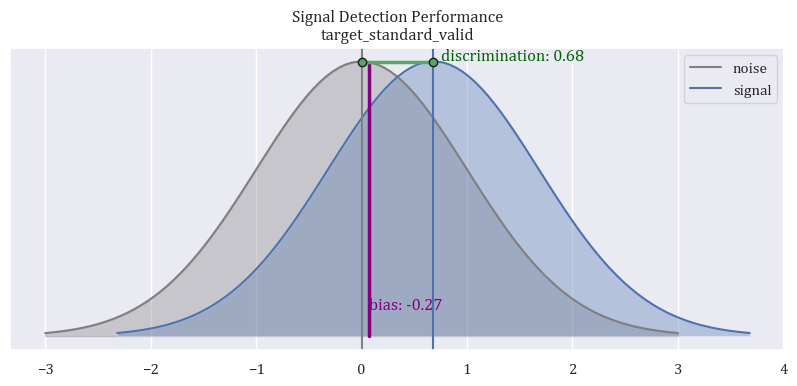

In [21]:
participant = 2
grouper = 'condition'
test = sdt_df.loc[(sdt_df['participant'] == participant) & (sdt_df[grouper] == 'distractor_salient_valid')]

dprime = test['d_prime'].item()
bias = test['c_bias'].item()

plot_signal_detection(dprime, bias, title='target_standard_valid')

### 4. Run the ROC analysis for a single subject

The key function here is `roc()`, which takes the following arguments:

`data`: the dataset
`y_true`: name of column containing the ground truth  
`y_classified`: name of column containing the classification judgements  
`response_type_column`: name of column containing the response types (tp, fn, fp, tn)  
`grouper`: name of the column containing the conditions/levels of the experimental design  
`responses`: the name of the columns containing all recorded responses along a continuous scale (e.g. from `[1,2,3,4,5,6]`)  
`tp`: the label to assign to the true positive rate (default is 'H' for hit)  
`fp`: label to assign to the false positive rate (default 'FA' for false alarm)  
`tn`: label to assign to the true negative rate (default 'CR' for correct rejection)  
`fn`: label to assign tto the false negative rate (default 'M' for miss)  

As part of this function, a helper function called `compute_roc()` is called, which takes two vectors: `signal` and `noise`. These are the number of responses for each level of the continuous response scale for the 'target present' ('signal') and the 'target absent' ('noise') trials, respectively. The returned vectors are the sensitivity and 1-specificity functions corresponding to each level of the continuous response scale. This can be used on its own when simple ROC curves are required. For example:

Example true positive result: [0.23888889 0.44444444 0.78333333 0.88888889 0.99444444]
Example false positive result: [0.03135314 0.07260726 0.27227723 0.62046205 0.99834983]


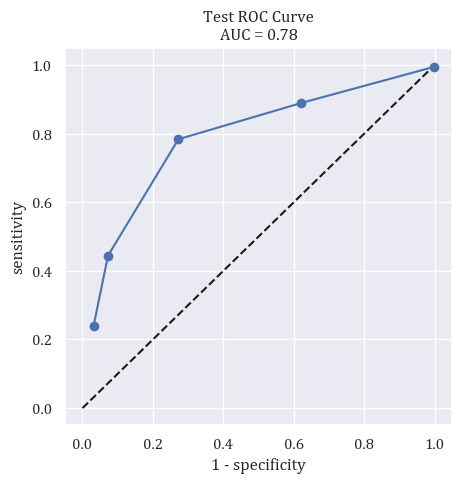

In [22]:
test_tp, test_fp = compute_roc(signal=[7,6,10,3,3,0],
                               noise=[3,4,20,35,38,0])
print(f'Example true positive result: {test_tp}')
print(f'Example false positive result: {test_fp}')

plot_roc(test_tp, test_fp, title='Test ROC Curve')

To run this over multiple subjects we just need to loop, and if saving then store the results as a list and use pd.concat()

In [23]:
participant = 3
df2 = df.loc[df['participant']==participant]
grouper = 'condition'
responses = 'trial_resp_keys'

roc_df = roc(df2, 'stimulus_class', 'response_class', 'response_type', grouper, responses)

roc_df.head(10)

,condition,trial_resp_keys,H,M,signal_count,FA,CR,noise_count,signal,noise,z_signal,z_noise
0,target_standard_valid,6.0,7,0,7,3,0,3,0.223958,0.031046,-0.758893,-1.865642
1,target_standard_valid,5.0,6,0,6,4,0,4,0.416667,0.071895,-0.210428,-1.461819
2,target_standard_valid,4.0,10,0,10,20,0,20,0.734375,0.269608,0.626099,-0.613999
3,target_standard_valid,3.0,0,4,4,0,35,35,0.864583,0.614379,1.101146,0.290751
4,target_standard_valid,2.0,0,4,4,0,39,39,0.994792,0.998366,2.561682,2.941338
5,target_standard_valid,1.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
6,target_salient_valid,6.0,11,0,11,3,0,3,0.348958,0.031046,-0.388134,-1.865642
7,target_salient_valid,5.0,8,0,8,4,0,4,0.604167,0.071895,0.264147,-1.461819
8,target_salient_valid,4.0,10,0,10,20,0,20,0.921875,0.269608,1.417797,-0.613999
9,target_salient_valid,3.0,0,1,1,0,35,35,0.958333,0.614379,1.731664,0.290751


Plot the ROC for an example condition

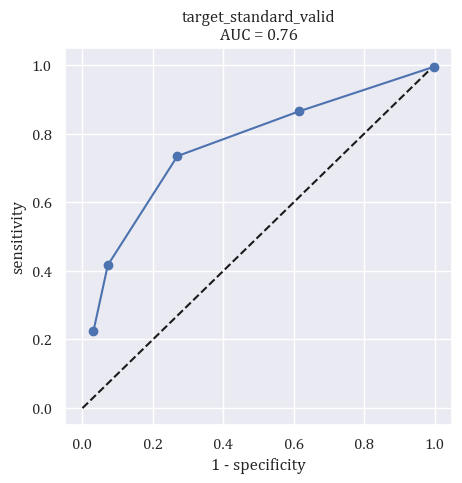

In [24]:
to_plot = roc_df.loc[roc_df[grouper] == 'target_standard_valid']
plot_roc(to_plot['signal'].values, to_plot['noise'].values, title='target_standard_valid')

Plot the ROCs for all conditions

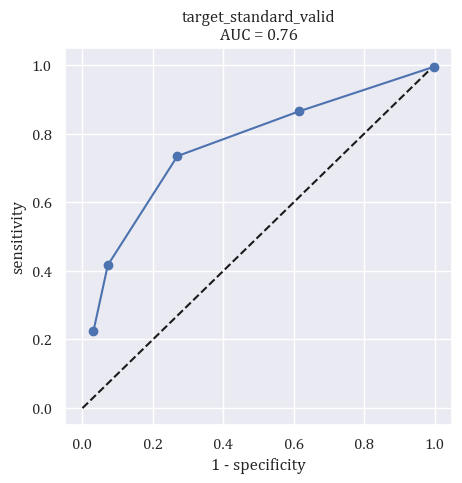

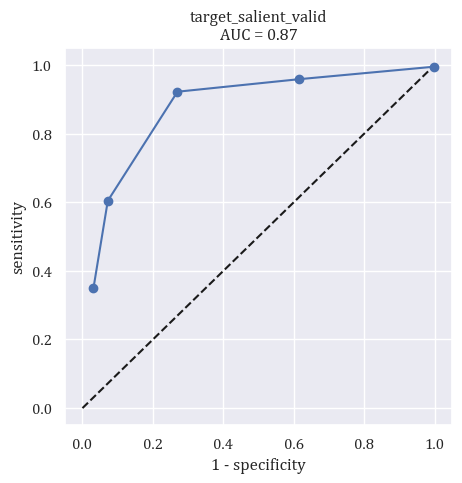

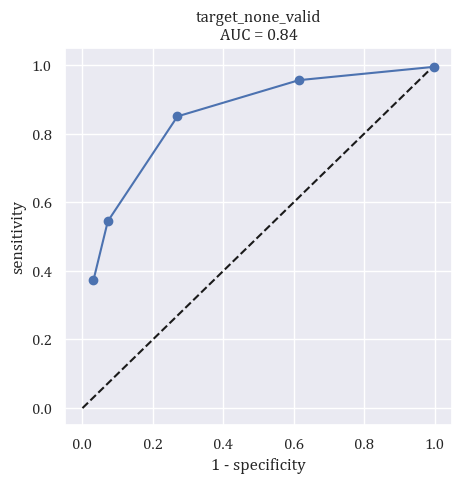

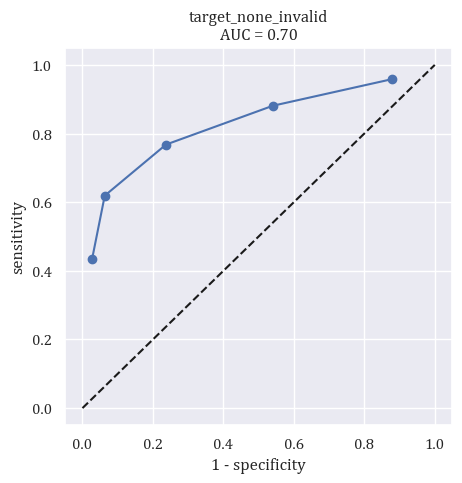

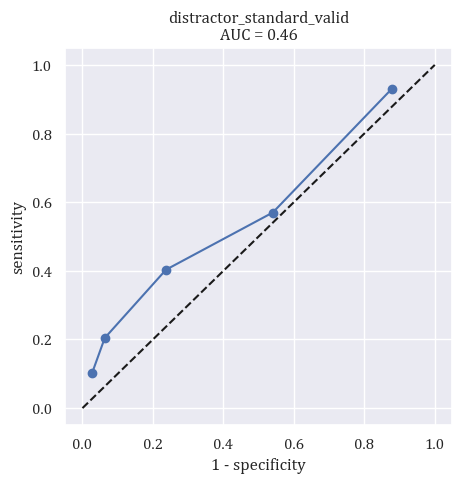

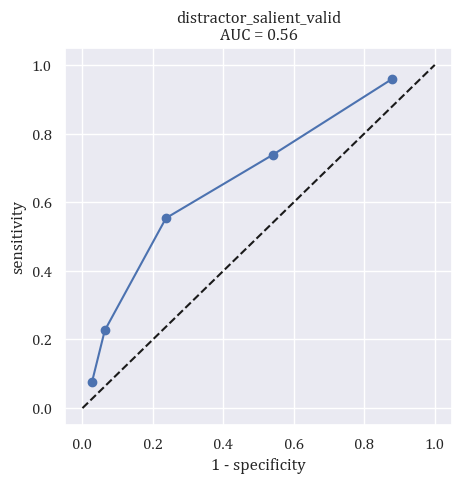

In [25]:
# Loop over all conditions in the data and plot the ROC
for g in roc_df[grouper].unique():
    to_plot = roc_df.loc[roc_df[grouper]==g]
    plot_roc(to_plot['signal'].values, to_plot['noise'].values, title=g)